## Setup

In [1]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.utils.nest_utils import batch_nested_array

In [2]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
tf.version.VERSION

'2.12.0'

## Hyperparameters

In [4]:
num_iterations = 20_000  # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 5e-4  # 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}

## Environment

In [5]:
env_name = 'Acrobot-v1'
env = suite_gym.load(env_name)

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


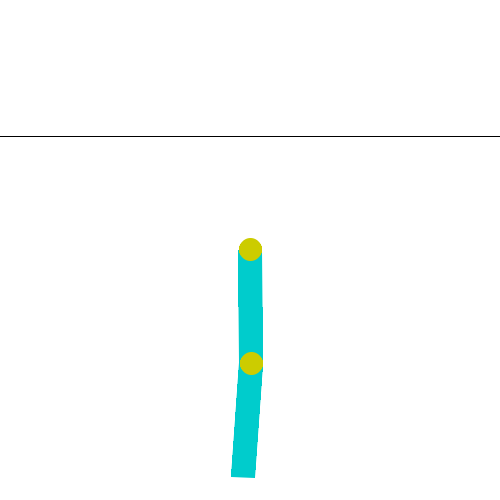

In [6]:
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(6,), dtype=dtype('float32'), name='observation', minimum=[ -1.        -1.        -1.        -1.       -12.566371 -28.274334], maximum=[ 1.        1.        1.        1.       12.566371 28.274334])


In [8]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [9]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In [10]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.99683964,  0.07943974,  0.9999425 ,  0.0107271 , -0.01354015,
       -0.01140255], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.9977252 ,  0.06741277,  0.9998928 ,  0.01464344, -0.10439499,
        0.04788967], dtype=float32),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [11]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [12]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [13]:
fc_layer_params = (1000, 500, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'
        )
    )


# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03
    ),
    bias_initializer=tf.keras.initializers.Constant(-0.2)
)
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    target_update_tau=0.1,  # soft updates
    gamma=1,  # discount factor
)

agent.initialize()

## Policies

In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [16]:
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)

In [17]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load(env_name)
)

In [18]:
time_step = example_environment.reset()

In [19]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Metrics and Evaluation

In [20]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [21]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-500.0

## Replay Buffer

In [22]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=replay_buffer_max_length
)

# rb_observer = replay_buffer.add_batch
rb_observer = lambda x: replay_buffer.add_batch(batch_nested_array(x))

# rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
#   replay_buffer.py_client,
#   table_name,
#   sequence_length=2)


In [23]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [24]:
# noinspection PyProtectedMember
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

In [25]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps
).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.9741744 ,  0.2257971 ,  0.9854877 ,  0.16974697,  0.55198574,
        -1.4381554 ], dtype=float32),
  'reward': array(-1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [26]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

In [27]:
# Dataset generates trajectories with shape [Bx2x...]
replayBufferDataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

replayBufferDataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 6), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [28]:
replayBufferIterator = iter(replayBufferDataset)
print(replayBufferIterator)

In [29]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the Agent

In [30]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(replayBufferIterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: loss = 0.9933971762657166
step = 2000: loss = 1.0345815420150757
step = 3000: loss = 1.800886869430542
step = 4000: loss = 1.1336827278137207
step = 5000: loss = 0.7884564399719238
step = 5000: Average Return = -85.5999984741211
step = 6000: loss = 1.1147829294204712
step = 7000: loss = 2.1133573055267334
step = 8000: loss = 0.6227318644523621
step = 9000: loss = 3.2336530685424805
step = 10000: loss = 0.516351580619812
step = 10000: Average Return = -76.4000015258789
step = 11000: loss = 1.517768383026123
step = 12000: loss = 0.6593119502067566
step = 13000: loss = 0.5935508012771606
step = 14000: loss = 1.3077646493911743
step = 15000: loss = 0.8756786584854126
step = 15000: Average Return = -72.19999694824219
step = 16000: loss = 0.72840952

## Visualization

(-521.3900001525878, 250.0)

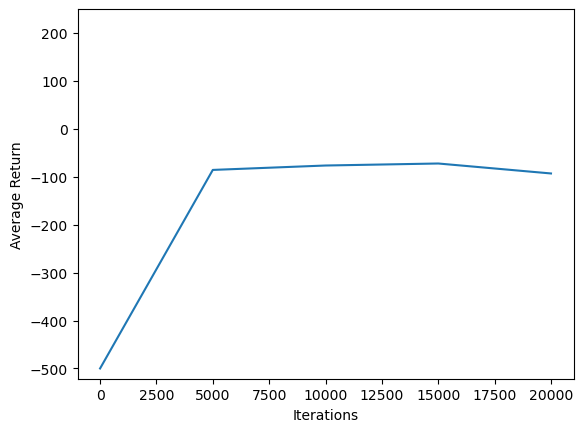

In [31]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [32]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [33]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


In [34]:
create_policy_eval_video(random_policy, "random-agent")